## (1) 사진을 준비하자

## Step 1. 인물모드 직접 해 보기  
* 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
* 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도

## CASE1 ) 배경 blur

(1546, 1546, 3)


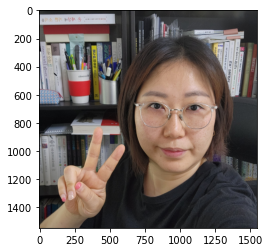

In [202]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img11.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

## 이미지 로드
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()



In [203]:


## 모델 load
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [204]:
## 세그멘테이션으로 사람분리
segvalues, output = model.segmentAsPascalvoc(img_path) 

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

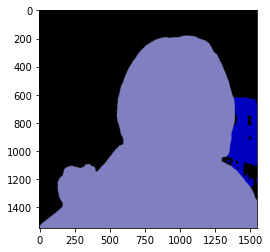

In [205]:
## 우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [206]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])


background
chair
person


In [207]:
# PixelLib에서 색상 코드 결과물이 확인

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [208]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

(1546, 1546)


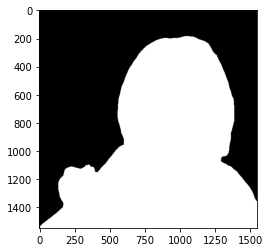

In [209]:
seg_color = (128,128,192) # 색상순서 변경 - BGR 순서 --> RGB 로

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

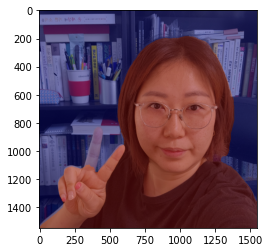

In [210]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

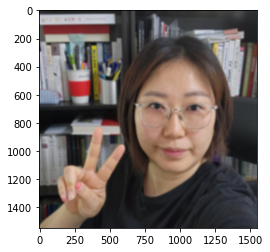

In [211]:
##  blur() 함수를 이용 배경흐리게 하기

img_orig_blur = cv2.blur(img_orig, (15,15)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

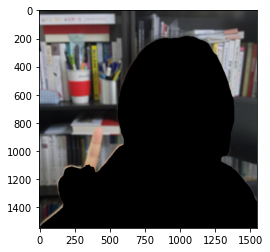

In [212]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

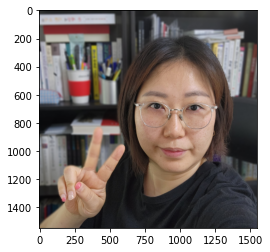

In [213]:
# 결과 출력
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## CASE2 ) 고양이 인식 blur

(4032, 3024, 3)


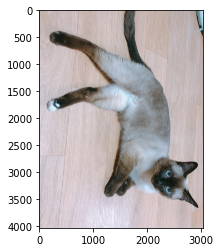

In [214]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/mycat1.png'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)

## 이미지 로드
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()


In [215]:
## 모델을 사용하여 세그멘테이션

segvalues, output = model.segmentAsPascalvoc(img_path2) 

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

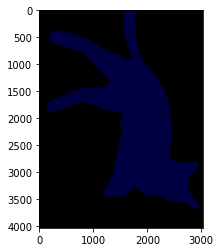

In [216]:
plt.imshow(output)
plt.show()

In [217]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [218]:
## 컬러 히트맵 만들기

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력



array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [219]:
colormap[8]

array([64,  0,  0])

In [220]:
colormap[0]
## 백그라운드로 바꿈

array([0, 0, 0])

(4032, 3024)


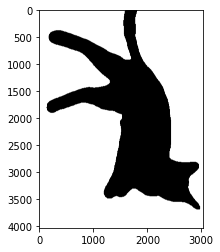

In [221]:
# RGB 변환

seg_color2 = (0,0, 0) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

seg_map2 = np.all(output==seg_color2, axis=-1) 
print(seg_map2.shape) 
plt.imshow(seg_map2, cmap='gray')
plt.show()


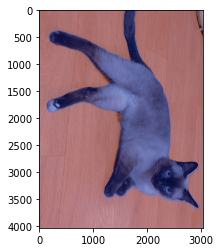

In [222]:
img_show2 = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

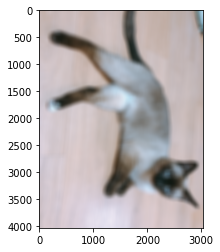

In [223]:
## 다. blur() 함수를 이용

# (13,13)은 blurring kernel size를 뜻합니다
## blur사이즈 변경  값이 커질수록 더울 흐려진다.
img_orig_blur2 = cv2.blur(img_orig2, (100,100))

plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

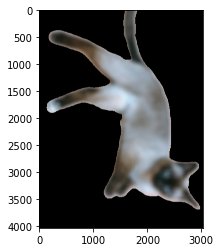

In [224]:
# 고양이랑 배경동일


img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)

plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()



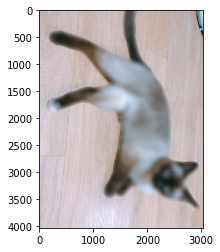

In [225]:
# 결과 출력
img_concat2 = np.where(img_mask_color2==255,   img_orig2 ,img_bg_blur2)

plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

####  화질이 선명하지 않지만 명확히 되었다
--> 배경을 추출해서 마스킹하는 방법말고 다른 코드를 생각해 보겠다


## CASE3 ) 배경 변경하기


(3024, 4032, 3)


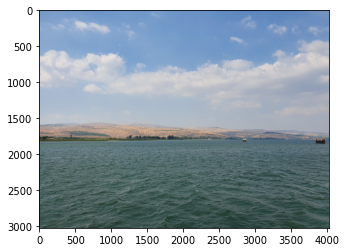

In [226]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg1.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)

## 이미지 로드
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()


(1536, 1152, 3)


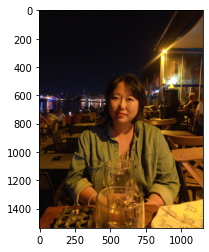

In [234]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2.png'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)

## 이미지 로드
# (3024, 4032, 3)
#resize_img_orig = cv2.resize(img_orig, ( 4032, 3024))
#print(resize_img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()
    

In [238]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output2 = model.segmentAsPascalvoc(img_path4) 


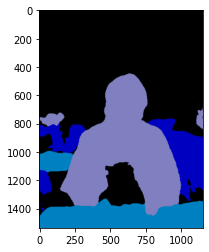

In [239]:
plt.imshow(output2)
plt.show()

In [240]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])


background
chair
diningtable
person


In [241]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [242]:
colormap[15]

array([192, 128, 128])

(1536, 1152)


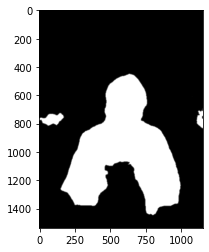

In [243]:
seg_color4 = (128,128,192) # 색상순서 변경 - BGR 순서 --> RGB 로

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map4 = np.all(output2==seg_color, axis=-1) 
print(seg_map4.shape) 
plt.imshow(seg_map4, cmap='gray')
plt.show()

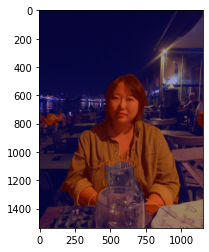

In [247]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show4 = img_orig4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask4 = seg_map4.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)


img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

(1536, 1152, 3)


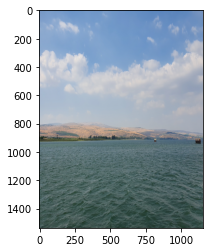

In [251]:


# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

 # 백그라운드 이미지 사이즈 변경
## 이미지 로드
# (3024, 4032, 3)
resize_img_orig3 = cv2.resize(img_orig3, ( 1152, 1536))
print(resize_img_orig3.shape)

plt.imshow(cv2.cvtColor(resize_img_orig3, cv2.COLOR_BGR2RGB))
plt.show()



## Step 2. 사진에서 문제점 찾기   

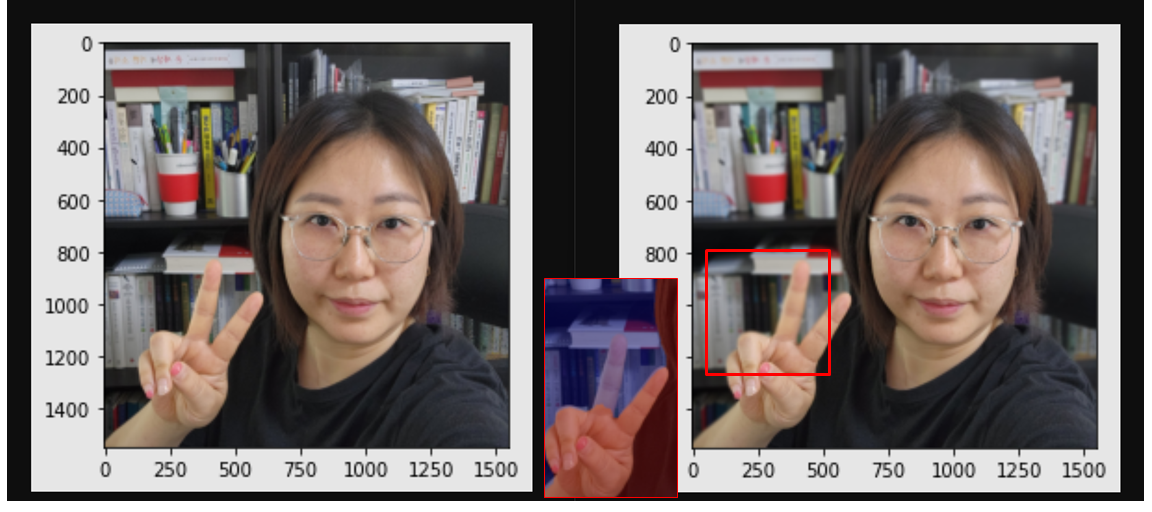
*  이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시
*  내가 만든 사진도 이상함 점을 표기  --> 손가락영역이 백그라운드 처리 되었다



## Step 3. 해결 방법을 제안해 보기  
* 솔루션: 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완
* 세그멘테이션의 한계
  - 피사계 심도 이해하기  
  - 3D Camera 활용하기
  - 소프트웨어 기술 활용하기
  - 다른 기술과 융합해 보기


손목과 백그라운드의 색상이 가까운거리의 색상이 유사할때 태그를 같은 클래스로 분류 하도록 하는 방법은 어떨까?   
얼굴과의 거리값을 계산하여 segmentation 에 반영하는건 어떨까?   
인체의 각부분 이나 신체 쉐입도 모델에 넣어서 학습하는것은?


## 회고
* 배운 점 : 함수의 args 을 많이 알아야 한다. 함수 사용법을 공부더해보자
* 아쉬운 점: 배경이미지 합성을 더 해보지 못해서 아쉽다
* 느낀 점 : 이미지 컨트롤을 하는것도 어렵지만 segmentation 에서 영역의 바운더리를 처리하는것이 어렵구나.  
  이미지 뿐만아니라 3D 카메라나 적외선 카메라의 데이터도 학습에 넣으면 해당 데이터들도 세그멘테이션을 정확히 할수있는 추가정보들이  
  있으니 점차 더 많은 정보를 가지고 학습을하게 될것이고, 카메라도 해상도에 따라 세그멘테이션 성능이 차이가 나는것 같아
  고품질의 이미지 데이터를 사용하는경우 모델이 정교해질 것 같다.
* 어려웠던 점 : 함수 사용안해봐서 잘 몰랐어서 어려웠다.. 이미지 해상도가 낮아서... 모델이 정확하게 영역을 라벨링 하지 못하는걸까? 
